# Dendrogram samples

This notebook applies the methods explored in [progress_report_4.ipynb](progress_report_4.ipynb) to an assortment of poems with different properties. It begins by consolidating the run script into a function, which is then called against different samples.

## Reload libraries each time, since we’re tinkering with them

In [1]:
%load_ext autoreload
%autoreload 2

## Load libraries

In [2]:
from xml.dom import pulldom  # parse input XML
from xml.dom.minidom import Document  # construct output XML
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
# see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from cyr2phon import cyr2phon  # custom package
pd.set_option('display.max_colwidth', -1) # show all text in cell, without truncation; default is 50

## Class and variables for parsing input XML

In [3]:
class Stack(list):  # keep track of open nodes while constructing XML output
    def push(self, item):
        self.append(item)

    def peek(self):  
        return self[-1]


open_elements = Stack()
WS_RE = re.compile(r'\s+')  # normalize white space in output

## Function to parse the XML

Returns a list of lists, with stanza number, line number, and `<line>` element for each line. We use the light-weight *xml.dom.pulldom* library to parse the input XML and *xml.dom.minidom* to construct the lines as simplified XML, removing elements we don’t care about, such as `<latin>` and `<italic>`, before serializing them to the output. (We actually do care about `<latin>`, but we are ignoring it temporarily, and we’ll return to it at a later stage in the project.)

In [4]:
def process(input_xml):
    poemId = ""
    stanzaNo = 0
    lineNo = 0
    inline = 0  # flag to control behavior inside and outside lines
    result = []  # array of arrays, one per line, with stanzaNo, lineNo, and serialized XML
    doc = pulldom.parse(input_xml)
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.localName == 'poem':
            poemId = node.getAttribute("opid")
        elif event == pulldom.START_ELEMENT and node.localName == 'stanza':
            stanzaNo = node.getAttribute("stanzaNo")
        elif event == pulldom.START_ELEMENT and node.localName == 'line':
            d = Document()  # each line is an output XML document
            open_elements.push(d)  # document node
            lineNo = node.getAttribute("lineNo")
            inline = 1  # we’re inside a line
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'line':
            inline = 0  # when we finish our work here, we’ll no longer be inside a line
            open_elements.pop()  # line is finished
            # serialize XML, strip declaration, rewrite &quot; entity as character
            result.append([poemId, int(stanzaNo), int(lineNo),
                WS_RE.sub(" " ,
                open_elements.pop().toxml().replace('<?xml version="1.0" ?>', '').replace('&quot;', '"'))])
        elif event == pulldom.START_ELEMENT and node.localName == 'stress':
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'stress':
            open_elements.pop()  # stress element is finished
        elif event == pulldom.CHARACTERS and inline:  # keep text only inside lines
            t = d.createTextNode(node.data)
            open_elements.peek().appendChild(t)
    return result

## Function to extract rhyme zone from rhyme word

In [5]:
rhymezonepat = re.compile(r'(.?[AEIOU]$)|([AEIOU].*$)')
def remove_pretonic_segments(s: str) -> str: # removes segments in place
    try:
        return rhymezonepat.search(s).group(0)
    except: # modify this to raise a real error, instead of just reporting
        print(s)

## Imports sample file, analyzes, outputs reports

In [6]:
def explore(filepath, ceiling=1000, ward=None):
    '''Render text and dendrograms of rhyme clustering
    
    Parameters:
        filepath (str): path to XML file with poem, required
        ceiling (int): maximum number of stanzas to return (useful for sampling long poems), 
            defaults to high value
        ward (boolean): show Ward dendrogram separately (improves legibility of long stanzas),
            defaults to None
    
    Does not return a value; all output is written directly from within the function
    '''
    
    # Read file
    with open(filepath) as f:
        data = process(f)
    df = pd.DataFrame(data, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
    
    # Prepare data
    trans_vec = np.vectorize(cyr2phon.transliterate)
    df["Phonetic"] = trans_vec(df["Text"])
    df["RhymeWord"] = df["Phonetic"].str.split().str[-1] # clitics have already been joined
    df["RhymeZone"] = df["RhymeWord"].apply(remove_pretonic_segments)
    df.loc[df["RhymeZone"].isnull(), "RhymeZone"] = "Abcde" # provisional placeholder for nulls
    df["tokenized"] = [x[0] for x in df["RhymeZone"].str.
                       findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]
    i = 0
    while pd.np.count_nonzero([item[i] for item in df["tokenized"]]) > 0:
        # print([item[i] for item in df["tokenized"]]) # diagnostic
        df["token" + str(i)] = [item[i] for item in df["tokenized"]]
        i += 1
    tokenheaders = df.filter(regex="^token\d").columns
    df[tokenheaders] = df[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
    df.filter(regex=r"StanzaNo|LineNo|RhymeWord|Text|^token\d").head() # columns we care about
    dummy = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)
    df = df.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeWord", "RhymeZone", "tokenized"])
    df.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
    
    # Visualize
    methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    stanzas = df.groupby(level=[0,1])
    pd.set_option('display.width', 1000) # don't wrap long rows
    for offset, (id, lines) in enumerate(stanzas):
        if offset < ceiling:
            print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines[["RhymeWord", "RhymeZone"]]], axis=1)) # diagnostic
            data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
            missing = data.filter(regex=r"missing$")
            missing = missing * 0.2 # reduce weight of missing values
            labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
            data.loc[:,"LineNo"] = [n / (len(labelList) * 2) for n in labelList] # scale to avoid tyranny of proximity, currently 0 <= n <= 0.5
            plt.figure(figsize=(20, 2))
            for n, m in enumerate(methods):
                linked = linkage(data, method=m)
                m_c, m_coph_dist = cophenet(linked, pdist(data))
                plt.subplot(1, 7, n + 1)
                plt.title(m + ": " + str(round(m_c, 3)))
                dendrogram(linked, labels=labelList)
            plt.show()
            if ward:
                linked = linkage(data, method="ward")
                labelList=list(range(1,len(lines)+1))
                c, coph_dist = cophenet(linked, pdist(data))
                plt.figure(figsize=(20, 10))
                plt.title("Ward: " + str(c))
                dendrogram(linked, labels=labelList)
                plt.show()
    pd.set_option('display.width', 80) # restore default
#     return df

## Test with Eugene Onegin chapter 1

                                                   Text  RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                      
Eo.1   1        1       "Мой дядя самых честных правил,  prAVil     AVil    
                2       Когда не в шутку занемог,        zaNimOk    Ok      
                3       Он уважать себя заставил         zastAVil   AVil    
                4       И лучше выдумать не мог.         NimOk      Ok      
                5       Его пример другим наука;         naUka      Uka     
                6       Но, боже мой, какая скука        skUka      Uka     
                7       С больным сидеть и день и ночь,  inOČ       OČ      
                8       Не отходя ни шагу прочь!         prOČ       OČ      
                9       Какое низкое коварство           kavArstva  Arstva  
                10      Полу-живого забавлять,           zabavLAT   AT      
                11      Ему подушки поправлять,          papravLAT  AT      

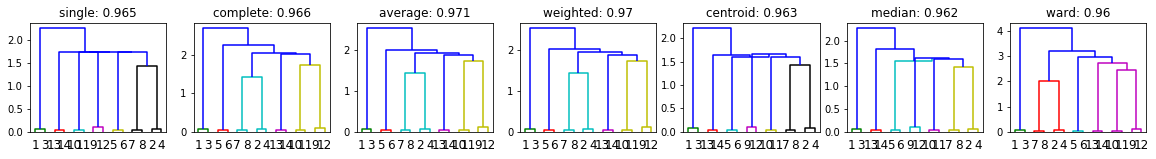

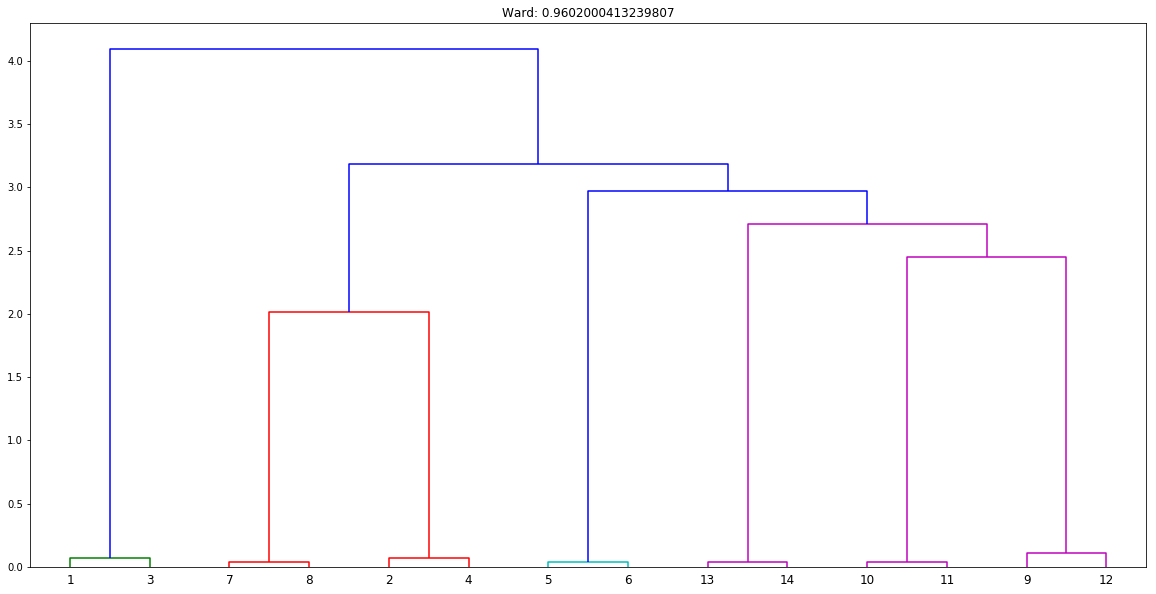

                                                 Text   RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                     
Eo.1   2        1       Так думал молодой повеса,      paVEsa      Esa     
                2       Летя в пыли на почтовых,       napaČtavIx  Ix      
                3       Всевышней волею Зевеса         ZiVEsa      Esa     
                4       Наследник всех своих родных.—  radnIx      Ix      
                5       Друзья Людмилы и Руслана!      iruslAna    Ana     
                6       С героем моего романа          ramAna      Ana     
                7       Без предисловий, сей же час    ČAs         As      
                8       Позвольте познакомить вас:     vAs         As      
                9       Онегин, добрый мой приятель,   pRiJATiL    ATiL    
                10      Родился на брегах Невы,        NivI        vI      
                11      Где может быть родились вы,    vI          vI      
            

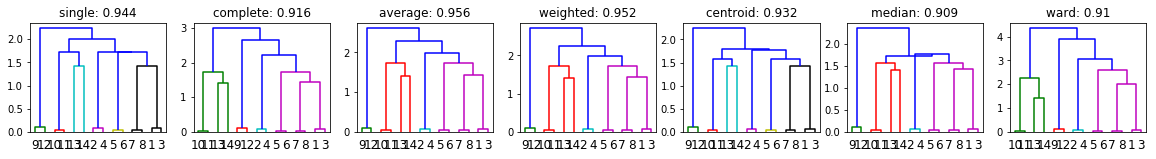

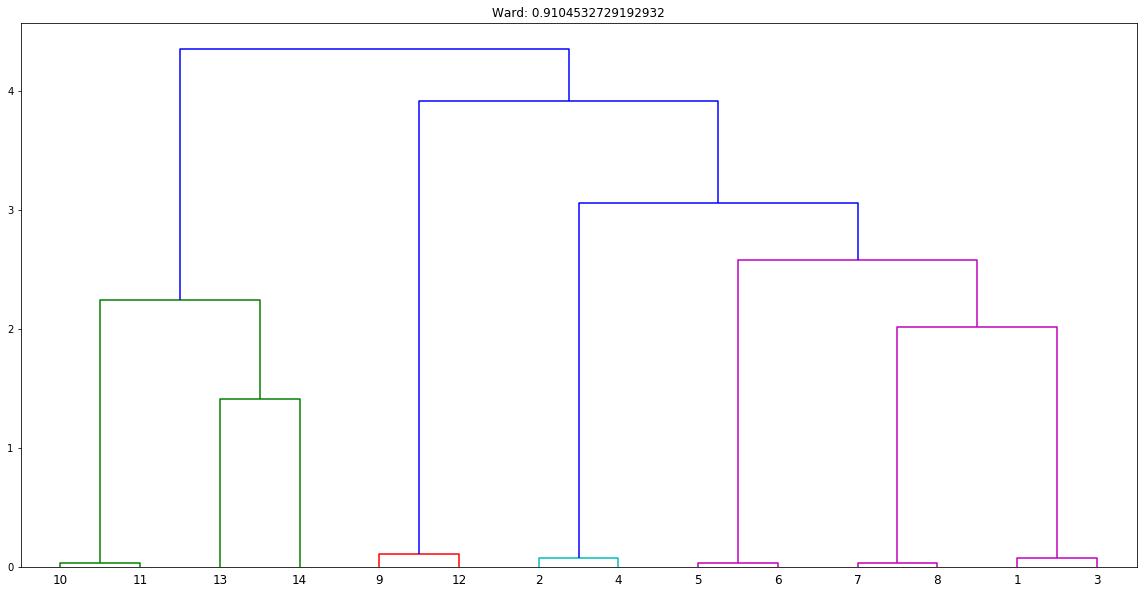

                                                     Text           RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                                 
Eo.1   3        1       Служив отлично-благородно,         aTLiČna-blagarOdna  Odna    
                2       Долгами жил его отец,              aTEts               Ets     
                3       Давал три бала ежегодно            JižigOdna           Odna    
                4       И промотался наконец.              nakaNEts            Ets     
                5       Судьба Евгения хранила:            xraNIla             Ila     
                6       Сперва Madame за ним ходила,       xaDIla              Ila     
                7       Потом Monsieur ее сменил;          sMiNIl              Il      
                8       Ребенок был резов, но мил.         naMIl               Il      
                9        Monsieur l'Abbé, француз убогой,  ubOgaJ              OgaJ    
                10      Чтоб не 

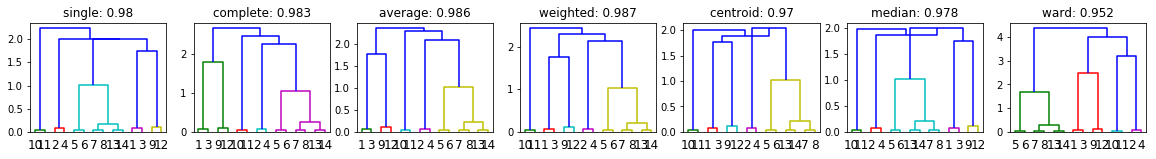

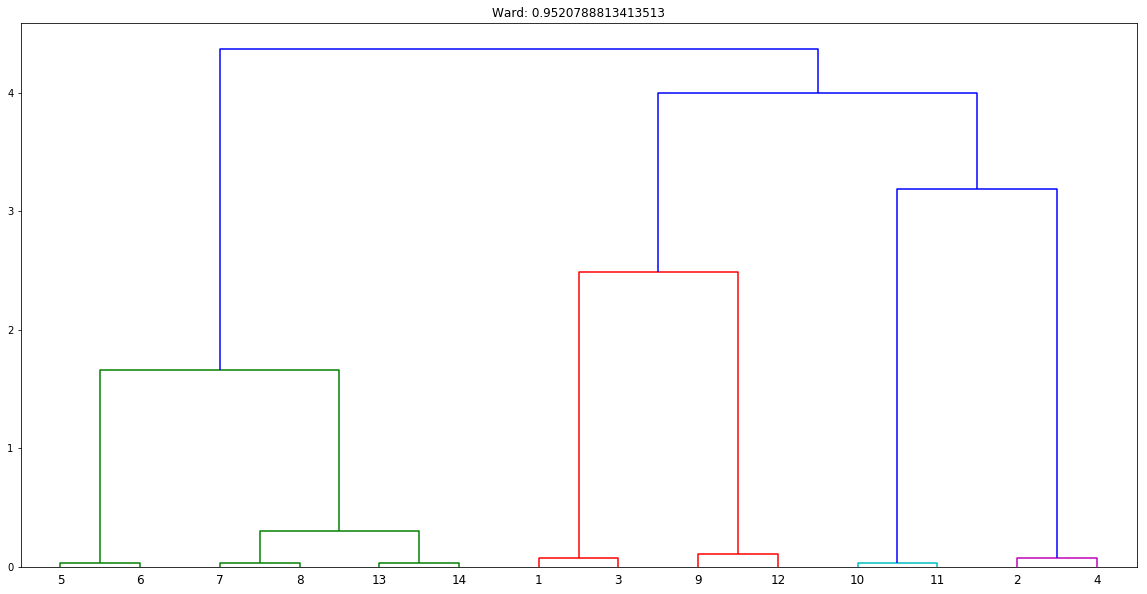

                                                  Text     RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                        
Eo.1   4        1       Когда же юности мятежной        MiTEžnaJ      EžnaJ   
                2       Пришла Евгению пора,            parA          rA      
                3       Пора надежд и грусти нежной,    NEžnaJ        EžnaJ   
                4        Monsieur прогнали со двора.    sadvarA       rA      
                5       Вот мой Онегин на свободе;      nasvabODi     ODi     
                6       Острижен по последней моде;     mODi          ODi     
                7       Как dandy лондонской одет—      aDEt          Et      
                8       И наконец увидел свет.          sVEt          Et      
                9       Он по-французски совершенно     saViršEna     Ena     
                10      Мог изьясняться и писал;        iPisAl        Al      
                11      Легко мазурку танцовал,     

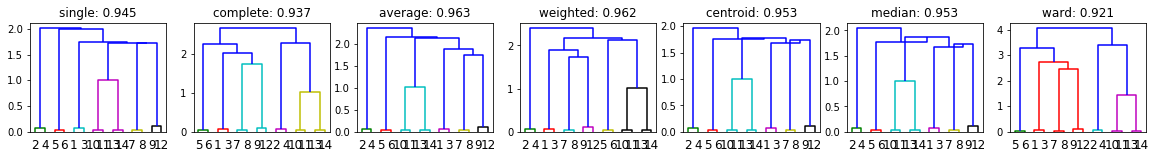

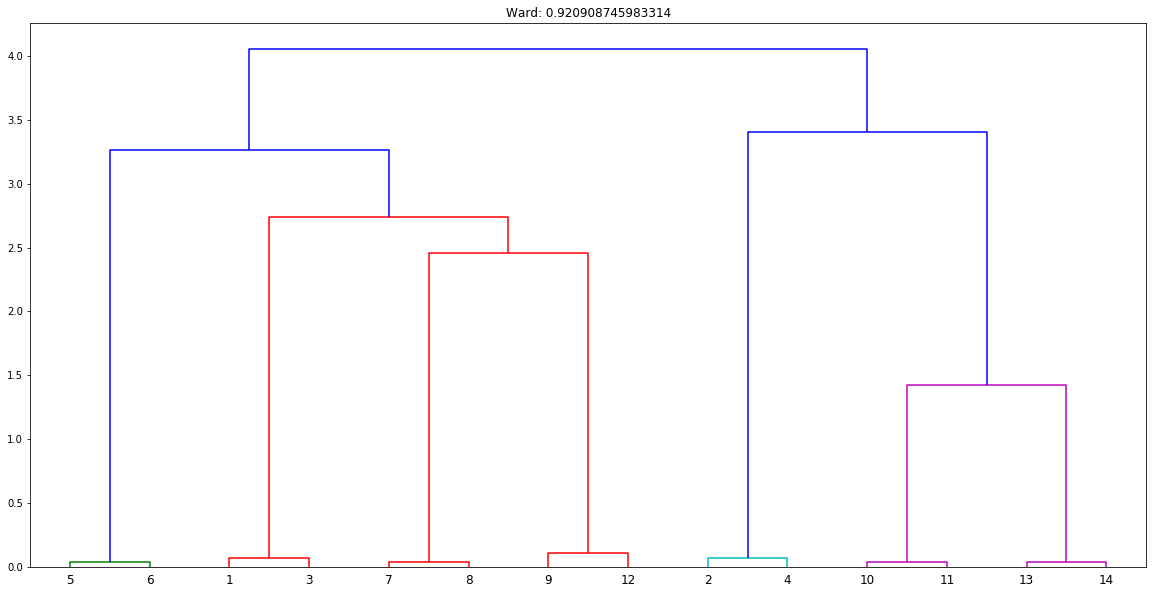

                                                    Text   RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                        
Eo.1   5        1       Мы все учились понемногу          paNimnOgu   Ogu     
                2       Чему-нибудь и как-нибудь,         ikak-NibUT  UT      
                3       Так воспитаньем, слава богу,      bOgu        Ogu     
                4       У нас немудрено блеснуть.         bLisnUT     UT      
                5       Онегин был по мненью многих       mnOGix      OGix    
                6       (Судей решительных и строгих)     istrOGix    OGix    
                7       Ученый малый, но педант:          naPidAnt    Ant     
                8       Имел он счастливый талант         talAnt      Ant     
                9       Без принужденья в разговоре       vrazgavORi  ORi     
                10      Коснуться до всего слегка,        SLikA       kA      
                11      С ученым видом знатока      

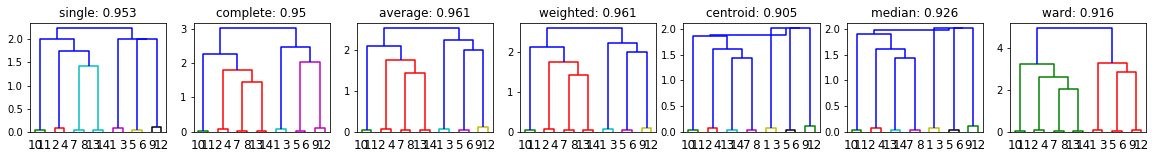

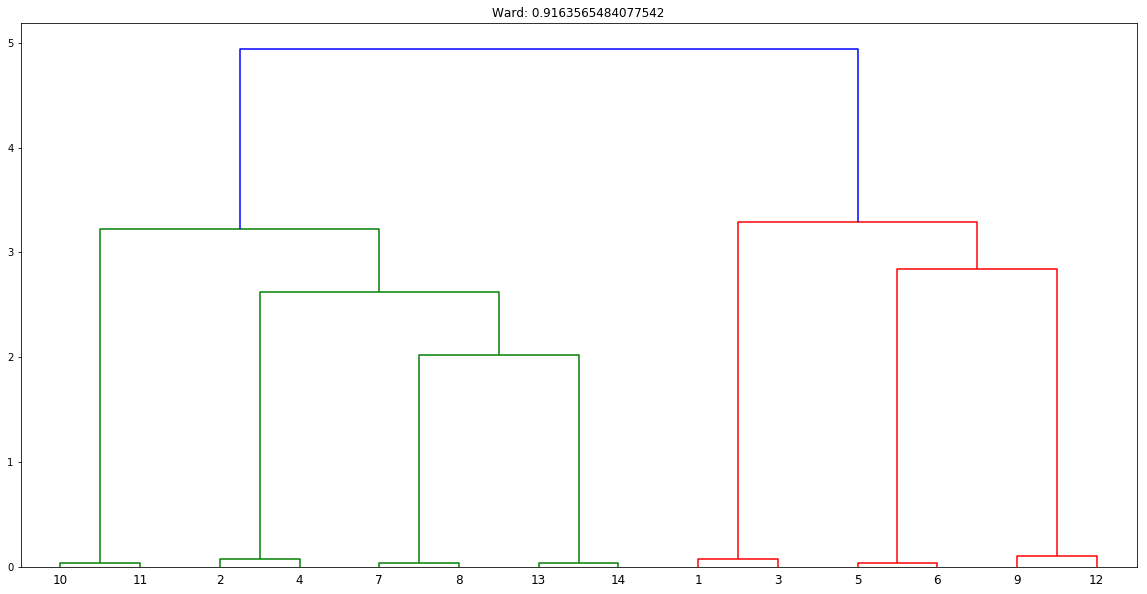

In [7]:
explore("data_samples/eo1.xml", 5, True) # no return; explore() writes the output

### Brjusov, “Voron” (1924)

Translation of Poe, “The raven”. Rhymes are not just pairs.

                                                                                          Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                
brjusov_voron_1924 1        1       Как-то в полночь, в час унылый, я вникал, устав, без силы,  BiSIli    Ili     
                            2       Меж томов старинных, в строки рассужденья одного            adnavO    vO      
                            3       По отвергнутой науке, и расслышал смутно звуки,             zvUKi     UKi     
                            4       Вдруг у двери словно стуки, — стук у входа моего.           maJivO    vO      
                            5       «Это — гость, — пробормотал я, — там, у входа моего.        maJivO    vO      
                            6       ‎Гость, — и больше ничего!»                                 NiČivO    vO      


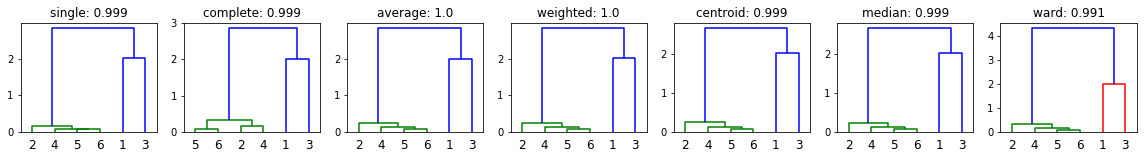

                                                                                        Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 2        1       Ах! мне помнится так ясно: был декабрь и день ненастный,  NinAstniJ  AstniJ  
                            2       Был как призрак — отсвет красный от камина моего.         maJivO     vO      
                            3       Ждал зари я в нетерпеньи, в книгах тщетно утешенье        uTišENJi   ENJi    
                            4       Я искал в ту ночь мученья, — бденья ночь, без той, кого   kavO       vO      
                            5       Звали здесь Линор. То имя… Шепчут ангелы его,             JivO       vO      
                            6       ‎На земле же — нет его.                                   JivO       vO      


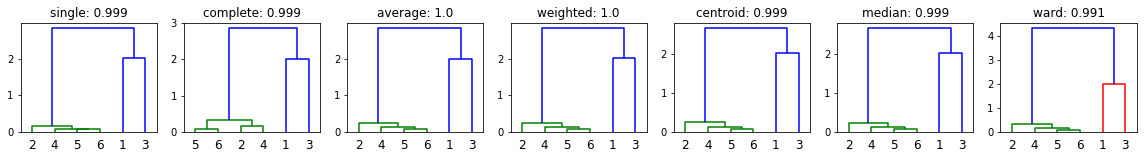

                                                                                    Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                           
brjusov_voron_1924 3        1       Шелковистый и не резкий, шорох алой занавески         zanaVEsKi  EsKi    
                            2       Мучил, полнил темным страхом, что не знал я до того.  datavO     vO      
                            3       Чтоб смирить в себе биенья сердца, долго в утешенье   vuTišENJi  ENJi    
                            4       Я твердил: «То — посещенье просто друга одного.»      adnavO     vO      
                            5       Повторял: «То — посещенье просто друга одного,        adnavO     vO      
                            6       ‎Друга, — больше ничего!»                             NiČivO     vO      


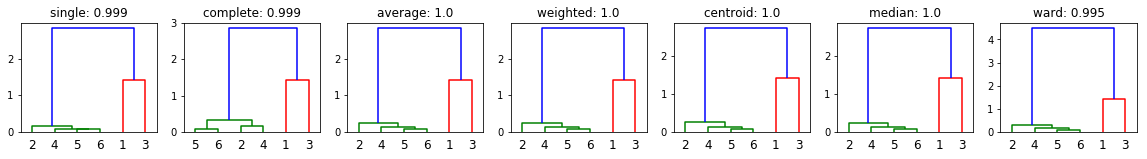

                                                                                   Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                          
brjusov_voron_1924 4        1       Наконец, владея волей, я сказал, не медля боле:      bOLi       OLi     
                            2       «Сэр иль Мистрисс, извините, что молчал я до того.   datavO     vO      
                            3       Дело в том, что задремал я, и не сразу расслыхал я,  raslixALi  ALi     
                            4       Слабый стук не разобрал я, стук у входа моего.»      maJivO     vO      
                            5       Говоря, открыл я настежь двери дома моего.           maJivO     vO      
                            6       ‎Тьма, — и больше ничего.                            NiČivO     vO      


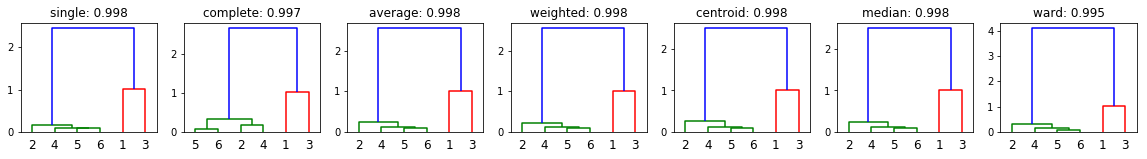

                                                                                     Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                           
brjusov_voron_1924 5        1       И, смотря во мрак глубокий, долго ждал я, одинокий,    aDinOKiJ  OKiJ    
                            2       Полный грез, что ведать смертным не давалось до того!  datavO    vO      
                            3       Все безмолвно было снова, тьма вокруг была сурова,     surOva    Ova     
                            4       Раздалось одно лишь слово: шепчут ангелы его.          JivO      vO      
                            5       Я шепнул: «Линор», и эхо — повторило мне его,          JivO      vO      
                            6       ‎Эхо, — больше ничего.                                 NiČivO    vO      


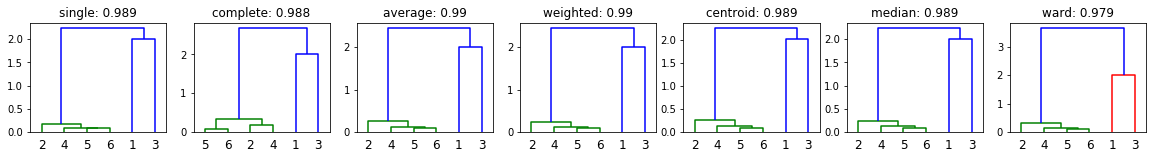

                                                                                     Text     RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 6        1       Лишь вернулся я несмело (вся душа во мне горела),      gaREla        Ela     
                            2       Вскоре вновь я стук расслышал, но ясней, чем до того.  datavO        vO      
                            3       Но сказал я: «Это ставней ветер зыблет своенравней,    svaJinrAvNiJ  AvNiJ   
                            4       Он и вызвал страх недавний, ветер, только и всего,     ifSivO        vO      
                            5       Будь спокойно, сердце! Это — ветер, только и всего.    ifSivO        vO      
                            6       ‎Ветер, — больше ничего!»                              NiČivO        vO      


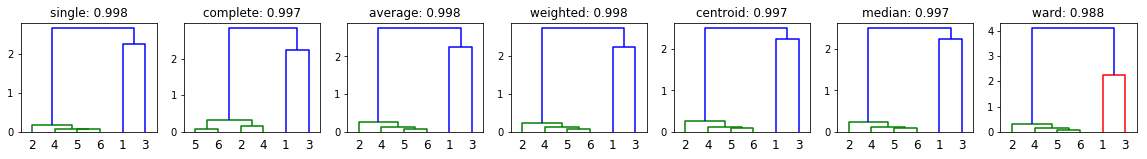

                                                                                      Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                             
brjusov_voron_1924 7        1       Растворил свое окно я, и влетел во глубь покоя          pakOJi     OJi     
                            2       Статный, древний Ворон, шумом крыльев славя торжество.  taržistvO  vO      
                            3       Поклониться не хотел он; не колеблясь, полетел он,      paLiTElan  Elan    
                            4       Словно лорд иль лэди, сел он, сел у входа моего,        maJivO     vO      
                            5       Там, на белый бюст Паллады, сел у входа моего,          maJivO     vO      
                            6       ‎Сел, — и больше ничего.                                NiČivO     vO      


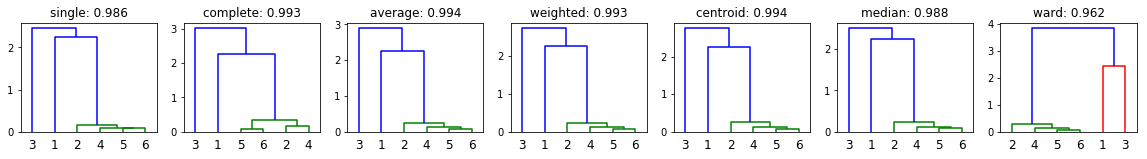

                                                                                            Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                  
brjusov_voron_1924 8        1       Я с улыбкой мог дивиться, как эбеновая птица,                 pTItsa    Itsa    
                            2       В строгой важности — сурова и горда была тогда.               tagdA     dA      
                            3       «Ты, — сказал я, — лыс и черен, но не робок и упорен,         iupORin   ORin    
                            4       Древний, мрачный Ворон, странник с берегов, где ночь всегда!  fSigdA    dA      
                            5       Как же царственно ты прозван у Плутона?» Он тогда             tagdA     dA      
                            6       ‎Каркнул: «Больше никогда!»                                   NikagdA   dA      


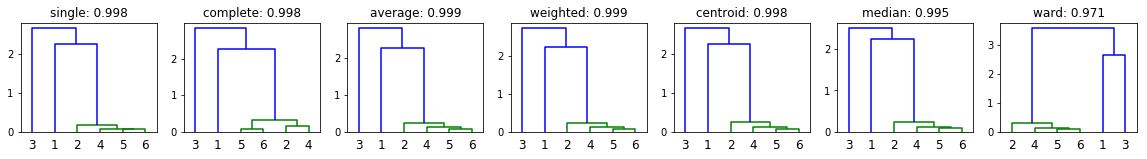

                                                                                Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                       
brjusov_voron_1924 9        1       Птица ясно прокричала, изумив меня сначала.       snaČAla    Ala     
                            2       Было в крике смысла мало, и слова не шли сюда.    SudA       dA      
                            3       Но не всем благословенье было — ведать посещенье  paSiQENJi  ENJi    
                            4       Птицы, что над входом сядет, величава и горда,    igardA     dA      
                            5       Что на белом бюсте сядет, чернокрыла и горда,     igardA     dA      
                            6       ‎С кличкой «Больше никогда!»                      NikagdA    dA      


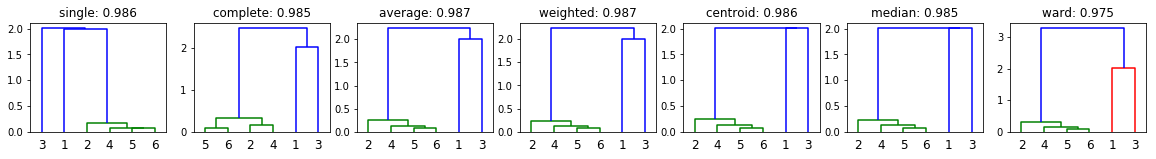

                                                                                      Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                            
brjusov_voron_1924 10       1       Одинокий, Ворон черный, сев на бюст, бросал, упорный,   upOrniJ   OrniJ   
                            2       Лишь два слова, словно душу вылил в них он навсегда.    nafSigdA  dA      
                            3       Их твердя, он словно стынул, ни одним пером не двинул,  NidVInul  Inul    
                            4       Наконец, я птице кинул: «Раньше скрылись без следа      BiSLidA   dA      
                            5       Все друзья; ты завтра сгинешь безнадежно!..» Он тогда   tagdA     dA      
                            6       ‎Каркнул: «Больше никогда!»                             NikagdA   dA      


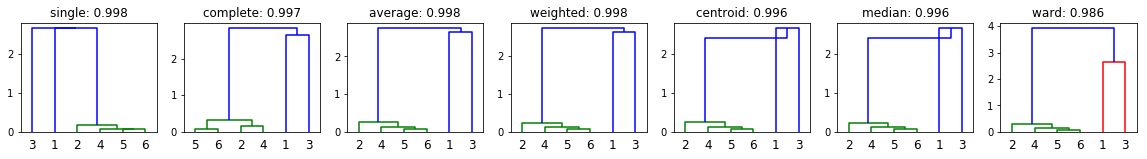

                                                                                          Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                
brjusov_voron_1924 11       1       Вздрогнул я, в волненьи мрачном, при ответе столь удачном.  udAČnam   AČnam   
                            2       «Это — все, — сказал я, — видно, что он знает, жив года     gadA      dA      
                            3       С бедняком, кого терзали беспощадные печали,                PiČALi    ALi     
                            4       Гнали в даль и дальше гнали неудачи и нужда.                inuždA    dA      
                            5       К песням скорби о надеждах лишь один припев нужда           nuždA     dA      
                            6       ‎Знала: больше никогда!»                                    NikagdA   dA      


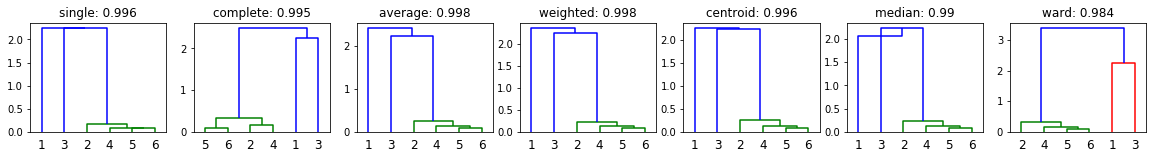

                                                                                      Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                            
brjusov_voron_1924 12       1       Я с улыбкой мог дивиться, как глядит мне в душу птица.  pTItsa    Itsa    
                            2       Быстро кресло подкатил я, против птицы, сел туда:       tudA      dA      
                            3       Прижимаясь к мягкой ткани, развивал я цепь мечтаний,    MiČtANiJ  ANiJ    
                            4       Сны за снами; как в тумане, думал я: «Он жил года,      gadA      dA      
                            5       Что ж пророчит, вещий, тощий, живший в старые года,     gadA      dA      
                            6       ‎Криком: больше никогда?»                               NikagdA   dA      


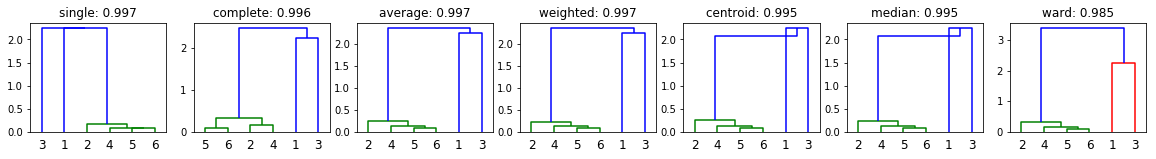

                                                                                   Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                         
brjusov_voron_1924 13       1       Это думал я с тревогой, но не смел шепнуть ни слога  NislOga   Oga     
                            2       Птице, чьи глаза палили сердце мне огнем тогда.      tagdA     dA      
                            3       Это думал и иное, прислонясь челом в покое           fpakOJi   OJi     
                            4       К бархату; мы, прежде, двое так сидели иногда…       inagdA    dA      
                            5       Ах! при лампе, не склоняться ей на бархат иногда     inagdA    dA      
                            6       ‎Больше, больше никогда!                             NikagdA   dA      


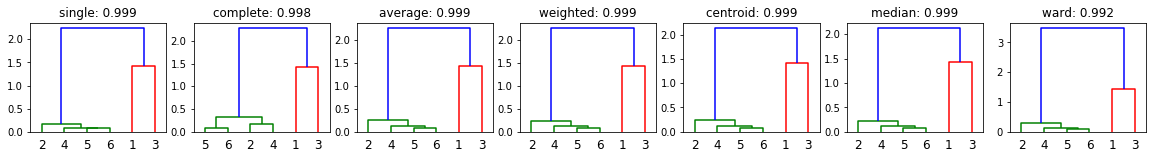

                                                                                             Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                   
brjusov_voron_1924 14       1       И, казалось, клубы дыма льет курильница незримо,               NizRIma   Ima     
                            2       Шаг чуть слышен серафима, с ней вошедшего сюда.                SudA      dA      
                            3       «Бедный! — я вскричал, — то богом послан отдых всем тревогам,  tRivOgam  Ogam    
                            4       Отдых, мир! чтоб хоть немного ты вкусил забвенье, — да?        dA        dA      
                            5       Пей! о, пей тот сладкий отдых! позабудь Линор, — о, да?        adA       dA      
                            6       ‎Ворон: «Больше никогда!»                                      NikagdA   dA      


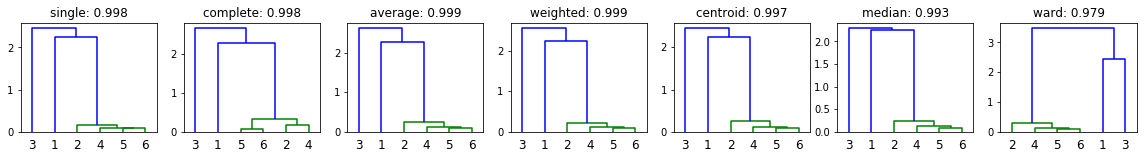

                                                                                         Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 15       1       «Вещий, — я вскричал, — зачем он прибыл, птица или демон?  iLiDEman  Eman    
                            2       Искусителем ли послан, бурей пригнан ли сюда?              SudA      dA      
                            3       Я не пал, хоть полн уныний! В этой за́клятой пустыне,      pustINi   INi     
                            4       Здесь, где правит ужас ныне, отвечай, молю, когда          kagdA     dA      
                            5       В Галааде мир найду я? обрету бальзам когда?»              kagdA     dA      
                            6       ‎Ворон: «Больше никогда!»                                  NikagdA   dA      


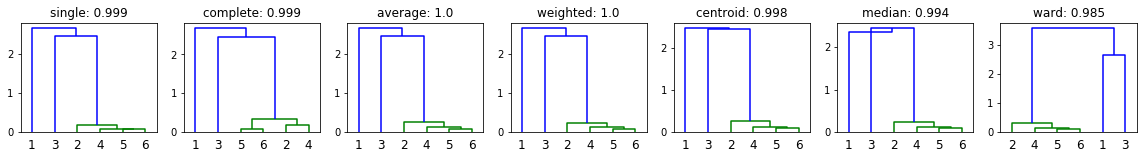

                                                                                         Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 16       1       «Вещий, — я вскричал, — зачем он прибыл, птица или демон?  iLiDEman  Eman    
                            2       Ради неба, что над нами, часа страшного суда,              sudA      dA      
                            3       Отвечай душе печальной: я в раю, в отчизне дальной,        dALnaJ    ALnaJ   
                            4       Встречу ль образ идеальный, что меж ангелов всегда?        fSigdA    dA      
                            5       Ту мою Линор, чье имя шепчут ангелы всегда?»               fSigdA    dA      
                            6       ‎Ворон: «Больше никогда!»                                  NikagdA   dA      


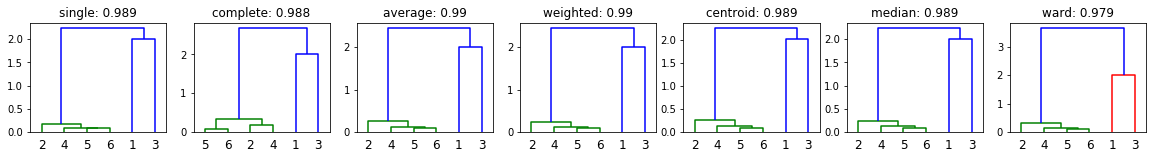

                                                                                            Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                   
brjusov_voron_1924 17       1       «Это слово — знак разлуки! — крикнул я, ломая руки.           rUKi       UKi     
                            2       Возвратись в края, где мрачно плещет Стиксова вода!           vadA       dA      
                            3       Не оставь здесь перьев черных, как следов от слов позорных!   pazOrnix   Ornix   
                            4       Не хочу друзей тлетворных! С бюста — прочь, и навсегда!       inafSigdA  dA      
                            5       Прочь — из сердца клюв, и с двери — прочь виденье навсегда!»  nafSigdA   dA      
                            6       ‎Ворон: «Больше никогда!»                                     NikagdA    dA      


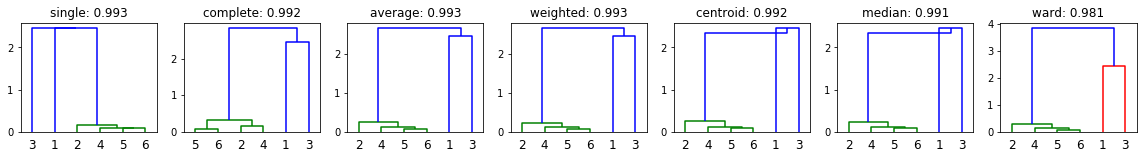

                                                                                          Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                
brjusov_voron_1924 18       1       И, как будто с бюстом слит он, все сидит он, все сидит он,  SiDItan   Itan    
                            2       Там, над входом, Ворон черный, с белым бюстом слит всегда!  fSigdA    dA      
                            3       Светом лампы озаренный, смотрит, словно демон сонный.       sOniJ     OniJ    
                            4       Тень ложится удлиненно, на полу лежит года, —               gadA      dA      
                            5       И душе не встать из тени, пусть идут, идут года, —          gadA      dA      
                            6       ‎Знаю, — больше никогда!                                    NikagdA   dA      


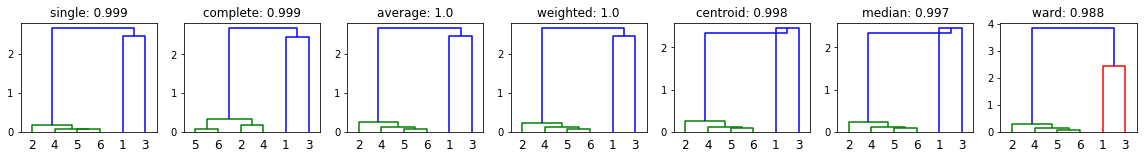

In [8]:
explore("data_samples/brjusov_voron.xml")

## Zinaida Gippius, “Neljubov′” (1907)

                                                                    Text RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                            
gippius_neljubov 1        1       Как ветер мокрый, ты бьешься в ставни,  fstAvNi   AvNi    
                          2       Как ветер черный, поешь: ты мой!        mOJ       OJ      
                          2       Я древний хаос, я друг твой давний,     dAvNiJ    AvNiJ   
                          4       Твой друг единый,— открой, открой!      atkrOJ    OJ      


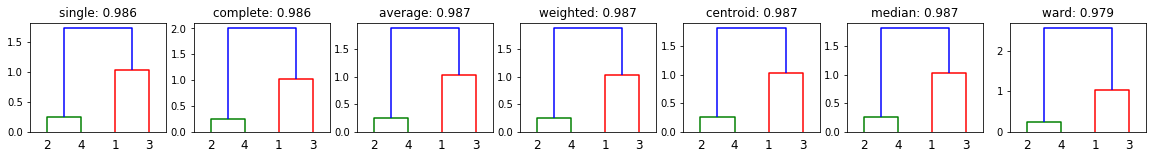

                                                              Text RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                      
gippius_neljubov 2        1       Держу я ставни, открыть не смею,  NisMEJu   EJu     
                          2       Держусь за ставни и страх таю.    taJU      JU      
                          3       Храню, лелею, храню, жалею        žaLEJu    EJu     
                          4       Мой луч последний — любовь мою.   maJU      JU      


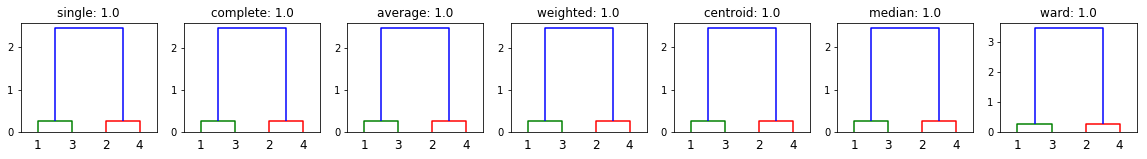

                                                              Text  RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                       
gippius_neljubov 3        1       Смеется хаос, зовет безокий:      BizOKiJ    OKiJ    
                          2       Умрешь в оковах,— порви, порви!   parVI      VI      
                          3       Ты знаешь счастье, ты одинокий,   aDinOKiJ   OKiJ    
                          4       В свободе счастье — и в Нелюбви.  ivNiLubVI  VI      


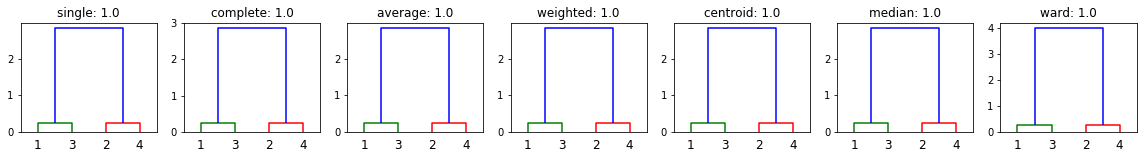

                                                         Text RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                 
gippius_neljubov 4        1       Охладевая, творю молитву,    maLItvu   Itvu    
                          2       Любви молитву едва творю…    tvaRU     RU      
                          3       Слабеют руки, кончаю битву,  BItvu     Itvu    
                          4       Слабеют руки… Я отворю!      atvaRU    RU      


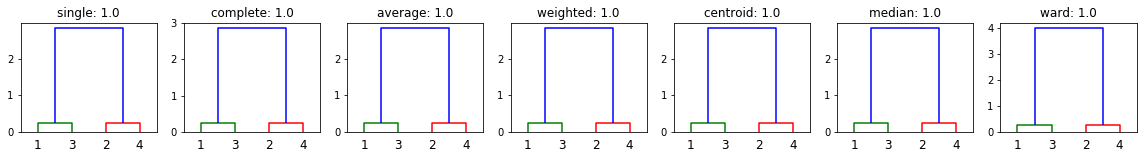

In [9]:
explore("data_samples/gippius_neljubov.xml")

## Anna Axmatova “On ljubil ...” (1910)

* Expect ABC′ABC′e, where the B rhyme is approximate (*[Inaf]* ~ *[InaJ]*). All methods find this except single.
    * Hmm ... now incorrectly pairing adjacent lines ... what changed?
* Line 7 is correctly unpaired, but how can it be recognized as a singleton, and not an approximate rhyme? 
* It isn’t clear why single linkage seems to fail, except that it is known to be buggy in general (<https://github.com/scipy/scipy/issues/7271>). Since it isn’t likely to be the top choice, it doesn’t have any practical consequences.
* Enrichment would be useful for the B rhymes, as would distinctive-feature matching for the pretonic *[p]* ~ *[m]*.

                                                                      Text RhymeWord RhymeZone
PoemId                  StanzaNo LineNo                                                       
axmatova_on-ljubil_1910 1        1       Он любил три вещи на свете:        nasVETi   ETi     
                                 2       За вечерней пенье, белых павлинов  pavLInaf  Inaf    
                                 3       И стертые карты Америки.           aMERiKi   ERiKi   
                                 4       Не любил, когда плачут дети,       DETi      ETi     
                                 5       Не любил чая с малиной             smaLInaJ  InaJ    
                                 6       И женской истерики.                iSTERiKi  ERiKi   
                                 7       …А я была его женой.               žinOJ     OJ      


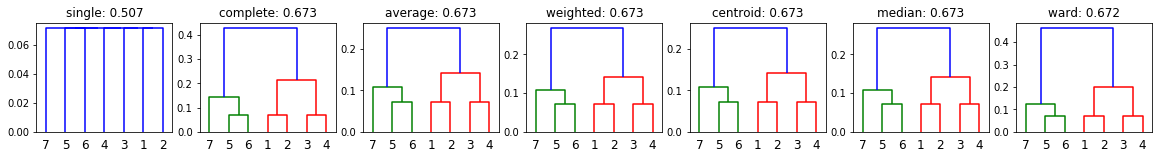

In [10]:
explore("data_samples/axmatova_on-ljubil.xml")

## Anna Axmatova, “Pamjati Sergeju Eseninu” (1925)

Finds inexact rhyme of lines 6 and 8 reliably.

                                                        Text RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                          
       1        1       Так просто можно жизнь покинуть эту,  Etu       Etu     
                2       Бездумно и безбольно догореть.        dagaRET   ET      
                3       Но не дано Российскому поэту          paEtu     Etu     
                4       Такою светлой смертью умереть.        uMiRET    ET      


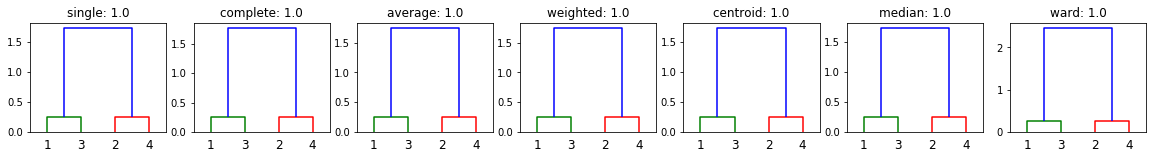

                                                          Text RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                            
       2        1       Всего верней свинец душе крылатой       krilAtaJ  AtaJ    
                2       Небесные откроет рубежи,                ruBižI    žI      
                3       Иль хриплый ужас лапою косматой         kasmAtaJ  AtaJ    
                4       Из сердца, как из губки, выжмет жизнь.  žIZN      IZN     


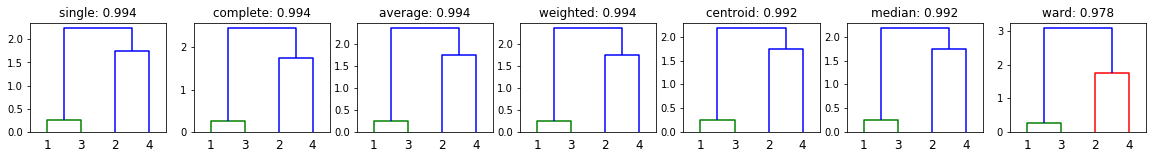

In [11]:
explore("data_samples/axmatova_pamjati-sergeju-eseninu.xml")

## Alexander Sergeevič Puškin, “Prorok” (1826)

                                                                 Text   RhymeWord RhymeZone
PoemId         StanzaNo LineNo                                                             
pushkin_prorok 1        1       Духовной жаждою томим,                 taMIm       Im      
                        2       В пустыне мрачной я влачился, —        vlaČIlSi    IlSi    
                        3       И шестикрылый серафим                  SiraFIm     Im      
                        4       На перепутье мне явился.               JiVIlSi     IlSi    
                        5       Перстами легкими как сон               sOn         On      
                        6       Моих зениц коснулся он.                On          On      
                        7       Отверзлись вещие зеницы,               ZiNItsi     Itsi    
                        8       Как у испуганной орлицы.               arLItsi     Itsi    
                        9       Моих ушей коснулся он, —               On       

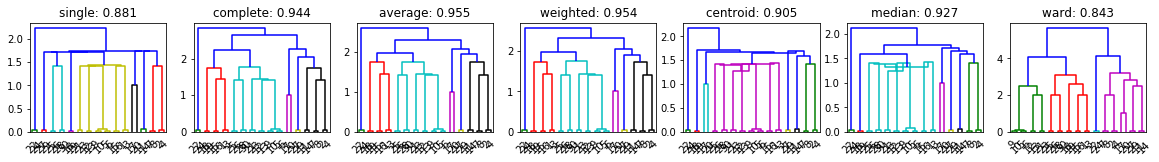

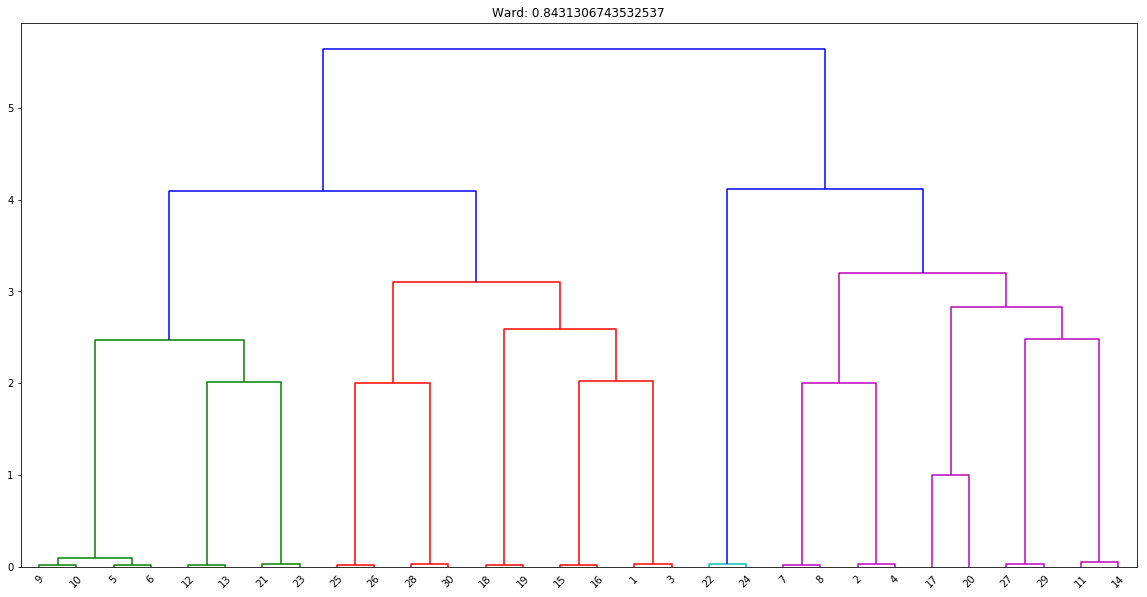

In [12]:
explore("data_samples/pushkin_prorok.xml",1000,True)

In [13]:
help(explore)

Help on function explore in module __main__:

explore(filepath, ceiling=1000, ward=None)
    Render text and dendrograms of rhyme clustering
    
    Parameters:
        filepath (str): path to XML file with poem, required
        ceiling (int): maximum number of stanzas to return (useful for sampling long poems), 
            defaults to high value
        ward (boolean): show Ward dendrogram separately (improves legibility of long stanzas),
            defaults to None
    
    Does not return a value; all output is written directly from within the function

